# Full deep learning model 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.tabular import *
from fastai.text import *
from fastai.metrics import accuracy

In [3]:
valid_sz = 10000
PATH = Path('~/data/').expanduser()

In [5]:
df = pd.read_feather(PATH/'listings-df')

# 1. Input models

## 1.1. Tabular model

### Data

In [6]:
df_tab = df.drop('title', axis=1) 

In [7]:
cont_cols = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6',
             'col7', 'col8', 'col9', 'col10', 'col11', 'col12'
             'title_isnew_prob'] # real columns names were replaced
cat_cols = sorted(list(set(df_tab.columns) - set(cont_cols) - {'condition'}))
valid_idx = range(len(df)-valid_sz, len(df))
procs = [FillMissing, Categorify, Normalize]

In [8]:
data_tab = (TabularList.from_df(df_tab, cat_cols, cont_cols, procs=procs, path=PATH)
            .split_by_idx(valid_idx)
            .label_from_df(cols='condition')
            .databunch())

### Model

In [9]:
learn_tab = tabular_learner(data_tab, layers=[64], ps=[0.5], emb_drop=0.05, metrics=accuracy)
learn_tab.load('tabular-model');

In [10]:
learn_tab.model.layers = learn_tab.model.layers[:-3]
learn_tab.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(10492, 50)
    (2): Embedding(3, 2)
    (3): Embedding(8, 5)
    (4): Embedding(1461, 50)
    (5): Embedding(286, 50)
    (6): Embedding(3481, 50)
    (7): Embedding(304, 50)
    (8): Embedding(570, 50)
    (9): Embedding(30, 16)
    (10): Embedding(26, 14)
    (11): Embedding(300, 50)
    (12): Embedding(33283, 50)
    (13): Embedding(5, 3)
    (14): Embedding(5, 3)
    (15): Embedding(3, 2)
    (16): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.05)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=462, out_features=64, bias=True)
    (1): ReLU(inplace)
  )
)

## 1.2. NLP Model

### Data

In [11]:
df_nlp = df[['title', 'condition']]

In [12]:
vocab = pickle.load(open(PATH/'itos', 'rb'))
data_nlp = TextClasDataBunch.from_df(PATH, df_nlp[:-valid_sz], df_nlp[-valid_sz:], 
                                     tokenizer=Tokenizer(lang='es'), 
                                     vocab=vocab, text_cols='title', label_cols='condition')

### Model

In [13]:
learn_nlp = text_classifier_learner(data_nlp, drop_mult=0.5)
learn_nlp.load('nlp-final');

In [14]:
learn_nlp.model[-1].layers = learn_nlp.model[-1].layers[:-3] 
learn_nlp.model

SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(22847, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(22847, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
    )
  )
)

# 2. Concat model

### Data

In [15]:
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, y): self.x1,self.x2,self.y = x1,x2,y
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return (self.x1[i], self.x2[i]), self.y[i]

train_ds = ConcatDataset(data_tab.train_ds.x, data_nlp.train_ds.x, data_tab.train_ds.y)
valid_ds = ConcatDataset(data_tab.valid_ds.x, data_nlp.valid_ds.x, data_tab.valid_ds.y)

In [16]:
def my_collate(batch):    
    x,y = list(zip(*batch))
    x1,x2 = list(zip(*x))
    x1 = to_data(x1)
    x1 = list(zip(*x1))
    x1 = torch.stack(x1[0]), torch.stack(x1[1])
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True)
    return (x1, x2), y

In [17]:
bs = 64
train_sampler = SortishSampler(data_nlp.train_ds.x, key=lambda t: len(data_nlp.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_nlp.valid_ds.x, key=lambda t: len(data_nlp.valid_ds[t][0].data))

In [18]:
train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
data = DataBunch(train_dl, valid_dl, device=defaults.device, collate_fn=my_collate, path=PATH)

In [19]:
(x1,x2),y = next(iter(data.train_dl))
print(f'Shape tabular batch (cats/cont): {x1[0].shape} / {x1[1].shape}')
print(f'Shape nlp batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape tabular batch (cats/cont): torch.Size([32, 17]) / torch.Size([32, 12])
Shape nlp batch: torch.Size([42, 32])
Shape dependent var: torch.Size([32])


### Model

In [20]:
class ConcatModel(nn.Module):
    def __init__(self, mod_tab, mod_nlp, layers, drops): 
        super().__init__()
        self.mod_tab = mod_tab
        self.mod_nlp = mod_nlp
        lst_layers = []
        activs = [nn.ReLU(inplace=True),] * (len(layers)-2) + [None]
        for n_in,n_out,p,actn in zip(layers[:-1], layers[1:], drops, activs):
            lst_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn)
        self.layers = nn.Sequential(*lst_layers)

    def forward(self, *x):
        x_tab = self.mod_tab(*x[0])
        x_nlp = self.mod_nlp(x[1])[0]
        x = torch.cat([x_tab, x_nlp], dim=1)
        return self.layers(x)    

In [21]:
lin_layers = [64+50, 2]
ps = [0.8]
model = ConcatModel(learn_tab.model, learn_nlp.model, lin_layers, ps)
model

ConcatModel(
  (mod_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(4, 3)
      (1): Embedding(10492, 50)
      (2): Embedding(3, 2)
      (3): Embedding(8, 5)
      (4): Embedding(1461, 50)
      (5): Embedding(286, 50)
      (6): Embedding(3481, 50)
      (7): Embedding(304, 50)
      (8): Embedding(570, 50)
      (9): Embedding(30, 16)
      (10): Embedding(26, 14)
      (11): Embedding(300, 50)
      (12): Embedding(33283, 50)
      (13): Embedding(5, 3)
      (14): Embedding(5, 3)
      (15): Embedding(3, 2)
      (16): Embedding(3, 2)
    )
    (emb_drop): Dropout(p=0.05)
    (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=462, out_features=64, bias=True)
      (1): ReLU(inplace)
    )
  )
  (mod_nlp): SequentialRNN(
    (0): MultiBatchRNNCore(
      (encoder): Embedding(22847, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(2284

### Learner

In [22]:
loss_func = nn.CrossEntropyLoss()
layer_groups = [nn.Sequential(*flatten_model(learn_nlp.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_nlp.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_nlp.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_nlp.layer_groups[3])),
                nn.Sequential(*(flatten_model(learn_nlp.layer_groups[4]) + 
                                flatten_model(model.mod_tab) +
                                flatten_model(model.layers)))] 
learn = Learner(data, model, loss_func=loss_func, metrics=accuracy, layer_groups=layer_groups)

### Train!

In [23]:
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


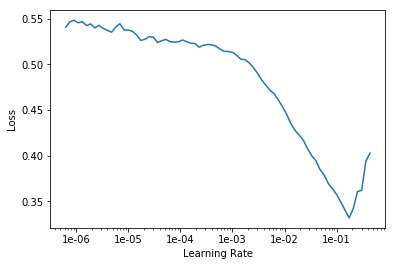

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

Total time: 00:37
epoch  train_loss  valid_loss  accuracy
1      0.106572    0.248390    0.920200  (00:37)



In [26]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

Total time: 00:40
epoch  train_loss  valid_loss  accuracy
1      0.086336    0.256554    0.919800  (00:40)



In [27]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7))

Total time: 01:03
epoch  train_loss  valid_loss  accuracy
1      0.097170    0.257217    0.919500  (01:03)



In [28]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

Total time: 07:04
epoch  train_loss  valid_loss  accuracy
1      0.080045    0.260310    0.920200  (01:24)
2      0.075644    0.249944    0.922800  (01:26)
3      0.071381    0.271557    0.920900  (01:26)
4      0.078788    0.290130    0.919600  (01:24)
5      0.088786    0.268973    0.921800  (01:23)



In [29]:
learn.fit_one_cycle(5, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7), wd=1e-1)

Total time: 06:51
epoch  train_loss  valid_loss  accuracy
1      0.077082    0.248748    0.924100  (01:21)
2      0.081846    0.249953    0.923700  (01:20)
3      0.088959    0.254498    0.920200  (01:23)
4      0.056842    0.249644    0.922800  (01:21)
5      0.067153    0.244735    0.922900  (01:24)

